In [1]:
import pickle
import os
import pandas as pd
import pyarrow
import pyarrow.parquet as pa

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
import numpy as np
import math

# This flag gives the possibility to run the code in testmode
# i.e. test prints and limited I/O output such that it does not exceed the buffer (e.g. only printing one user) 
TEST = True

In [2]:
# Read in user history, i.e. dictionary containing all histories per user {<user_id>: {<article_id>, ...}}
user_history_path = "../DATA/user_history_selection/histories_pickle.txt"
user_history = pickle.load(open(user_history_path, 'rb'))

In [3]:
# TEST PRINT
if TEST:
    K = 1
    res = dict(list(user_history.items())[0: K])
    print(res)

{'2444624': {'9756441', '9741802', '9740843', '9740121', '9738490', '9743702', '9751411', '9750872', '9764362', '9766944', '9747320', '9744530', '9751290', '9759927', '9745661', '9751508', '9738567', '9742775', '9740182', '9757533', '9756941', '9748447', '9761464', '9759461', '9752566', '9742735', '9768564', '9745079', '9508202', '9766136', '9765185', '9764049', '9745674', '9746345', '9760944', '9750904', '9760608', '9741415', '9750876', '9751524', '9745154', '9757378', '9749873', '9761288', '9766949', '9760288', '9737143', '9740400', '9757193', '9741804', '9763721', '9748760', '9768467', '9748792', '9767507', '9770030', '9768193', '9768997', '9766919', '9741788', '9743831', '9764070', '9761372', '9741144', '9740106', '9752890', '9760140', '9759109', '9745643', '9768328', '9738447', '9756028', '9760962', '9748470', '9763090', '9761359', '9753415', '9749729', '9744263', '9768882', '9549298', '9764642', '9725209', '9752656', '9747796', '9749034', '9748134', '9761788', '9746033', '9741783

In [4]:
user_articles_info_path = "../DATA/user_history_selection/final_cluster_data.txt"
user_articles_info = pickle.load(open(user_articles_info_path, 'rb'))

In [5]:
# TEST PRINT
if TEST:
    K = 1
    res = dict(list(user_articles_info.items())[0: K])
    print(res)

{'2444624': {'topics': [array(['Underholdning', 'Film og tv'], dtype=object), array(['Kriminalitet', 'Bedrageri', 'Erhverv', 'Privat virksomhed',
       'Kendt', 'Økonomi', 'Politik', 'International politik'],
      dtype=object), array(['Kendt', 'Begivenhed', 'Sport', 'Sportsbegivenhed', 'Cykling'],
      dtype=object), array(['International politik', 'Konflikt og krig', 'Væbnet konflikt',
       'Politik'], dtype=object), array(['Transportmiddel', 'Bil'], dtype=object), array(['Kendt', 'Begivenhed', 'Sport', 'Sportsbegivenhed', 'Motorsport'],
      dtype=object), array(['Erhverv', 'Privat virksomhed', 'Politik', 'International politik'],
      dtype=object), array(['Transportmiddel', 'Bil', 'Katastrofe', 'Større transportmiddel'],
      dtype=object), array(['Kriminalitet', 'Kendt', 'Økonomi', 'Politik', 'National politik'],
      dtype=object), array(['Kriminalitet', 'Personfarlig kriminalitet'], dtype=object), array(['Kriminalitet', 'Erhverv', 'Privat virksomhed', 'Sport', 'Fodbold

In [6]:
print(len(user_articles_info), "users")

19704 users


In [7]:
if TEST:
    example_user_id = '1404234' #list(user_articles_info.keys())[0]
    print("User", example_user_id)
    print(user_articles_info[example_user_id])

User 1404234
{'topics': [array(['Politik', 'International politik', 'Konflikt og krig',
       'National politik', 'Væbnet konflikt'], dtype=object), array(['Erhverv', 'Privat virksomhed', 'Samfund', 'Økonomi', 'Politik',
       'National politik'], dtype=object), array(['Erhverv', 'Privat virksomhed', 'Økonomi', 'Mikro', 'Politik',
       'National politik'], dtype=object), array(['Erhverv', 'Samfund', 'Økonomi', 'Mikro', 'Bolig'], dtype=object), array(['Erhverv', 'Privat virksomhed', 'Teknologi'], dtype=object), array(['Kendt', 'Underholdning', 'Musik og lyd'], dtype=object), array(['Kendt', 'Underholdning', 'Film og tv', 'Musik og lyd'],
      dtype=object), array(['Kriminalitet', 'Personfarlig kriminalitet'], dtype=object), array(['Erhverv', 'Sport', 'Fodbold', 'Ansættelsesforhold'], dtype=object), array(['Sundhed', 'Sygdom og behandling'], dtype=object), array(['Underholdning', 'Film og tv', 'Samfund', 'Værdier'], dtype=object), array(['Kriminalitet', 'Personfarlig kriminalitet'],

In [8]:
df_ua_info = pd.DataFrame(user_articles_info).T

if TEST:
    display(df_ua_info)

# Compute what the average 'page_views' is for a user given the whole dataset, 
# i.e. the average 'page_views' for whole dataset of the average 'page_views' per user history
count_user_avg_page_views = np.array([])
for page_views in df_ua_info["page_views"]:
    user_avg_page_views = np.nanmean(np.array(page_views)) 
    count_user_avg_page_views = np.append(count_user_avg_page_views, user_avg_page_views)

avg_avg_user_page_views = np.nanmean(count_user_avg_page_views)
print("On average, the average 'page_views' per user is", avg_avg_user_page_views)

topics  \
2444624  [[Underholdning, Film og tv], [Kriminalitet, B...   
2462626  [[Samfund], [Kendt, Underholdning, Film og tv]...   
1619335  [[Begivenhed, Sport, Sportsbegivenhed, Motorsp...   
1867788  [[Samfund], [Samfund, Bæredygtighed og klima, ...   
2408610  [[Transportmiddel, Konflikt og krig, Større tr...   
...                                                    ...   
295336   [[Erhverv, Privat virksomhed, Økonomi], [Begiv...   
380901   [[Samfund], [Kriminalitet, Bedrageri, Erhverv,...   
1133867  [[Uddannelse, Grundskole], [Kendt, Livsstil, U...   
1221343  [[Kriminalitet, Bedrageri, Erhverv, Privat vir...   
1957332  [[Samfund], [Begivenhed, Sport, Fodbold, Sport...   

                                                 sentiment  \
2444624  [0.868399977684021, 0.9979000091552734, 0.8687...   
2462626  [0.9352999925613403, 0.5896999835968018, 0.709...   
1619335  [0.9265000224113464, 0.9352999925613403, 0.563...   
1867788  [0.9352999925613403, 0.6398000121116638, 0.749...   
2408610  [0.7325999736785889, 0.868399977684021, 0.9979...   
...                                                    ...   
295336   [0.9803000092506409, 0.902899980545044, 0.9176...   
380901   [0.9352999925613403, 0.9979000091552734, 0.927...   
1133867  [0.9247999787330627, 0.9952999949455261, 0.995...   
1221343  [0.9979000091552734, 0.9273999929428101, 0.907...   
1957332  [0.9352999925613403, 0.902899980545044, 0.9979...   

                                                page_views  \
2444624  [nan, 152285.0, 91552.0, 88676.0, 77458.0, 501...   
2462626  [126400.0, 28998.0, 76735.0, 139009.0, 762726....   
1619335  [83925.0, 126400.0, 87151.0, 77903.0, 91406.0,...   
1867788  [126400.0, 32410.0, 99376.0, 76735.0, 88676.0,...   
2408610  [208126.0, nan, 152285.0, 158562.0, 111243.0, ...   
...                                                    ...   
295336   [44211.0, 42601.0, 60109.0, 52040.0, 38253.0, ...   
380901   [126400.0, 152285.0, 82846.0, 76735.0, 91552.0...   
1133867  [80438.0, 109994.0, 54769.0, 57249.0, 63143.0,...   
1221343  [152285.0, 82846.0, 139009.0, 69125.0, 183259....   
1957332  [126400.0, 42601.0, 152285.0, 139009.0, 53521....   

                                            time_published  \
2444624  [2022-12-25 08:41:59, 2023-05-16 16:44:29, 202...   
2462626  [2023-05-20 17:24:27, 2023-04-09 18:00:44, 202...   
1619335  [2023-05-17 11:16:30, 2023-05-20 17:24:27, 202...   
1867788  [2023-05-20 17:24:27, 2023-05-16 10:44:34, 202...   
2408610  [2023-04-30 18:35:33, 2022-12-25 08:41:59, 202...   
...                                                    ...   
295336   [2023-05-10 06:08:15, 2023-05-16 18:34:45, 202...   
380901   [2023-05-20 17:24:27, 2023-05-16 16:44:29, 202...   
1133867  [2023-05-24 18:02:09, 2023-05-21 17:05:37, 202...   
1221343  [2023-05-16 16:44:29, 2023-05-16 02:54:55, 202...   
1957332  [2023-05-20 17:24:27, 2023-05-16 18:34:45, 202...   

                                                     index  
2444624  {0: '9558040', 1: '9767557', 2: '9760386', 3: ...  
2462626  {0: '9773877', 1: '9700156', 2: '9780181', 3: ...  
1619335  {0: '9769891', 1: '9773877', 2: '9740551', 3: ...  
1867788  {0: '9773877', 1: '9767725', 2: '9739333', 3: ...  
2408610  {0: '9743574', 1: '9558040', 2: '9767557', 3: ...  
...                                                    ...  
295336   {0: '9757218', 1: '9767642', 2: '9763799', 3: ...  
380901   {0: '9773877', 1: '9767557', 2: '9766242', 3: ...  
1133867  {0: '9779705', 1: '9775142', 2: '9775873', 3: ...  
1221343  {0: '9767557', 1: '9766242', 2: '9773887', 3: ...  
1957332  {0: '9773877', 1: '9767642', 2: '9767557', 3: ...  

[19704 rows x 5 columns]

On average, the average 'page_views' per user is 110880.13820090744


/tmp/ipykernel_179235/2920062914.py:10: RuntimeWarning: Mean of empty slice
  user_avg_page_views = np.nanmean(np.array(page_views))


Processing user 1404234:   0%|                            | 0/1 [00:00<?, ?it/s]

Number of articles 108
cophenetic coefficient 0.6394019977840467
cophenetic distances [24.22068688 24.22068688 24.22068688 ... 26.56114703  2.65849607
 26.56114703]
Number of cophenetic distances 5778
Min cophenetic distance threshold = 0
Max cophenetic distance threshold = 27


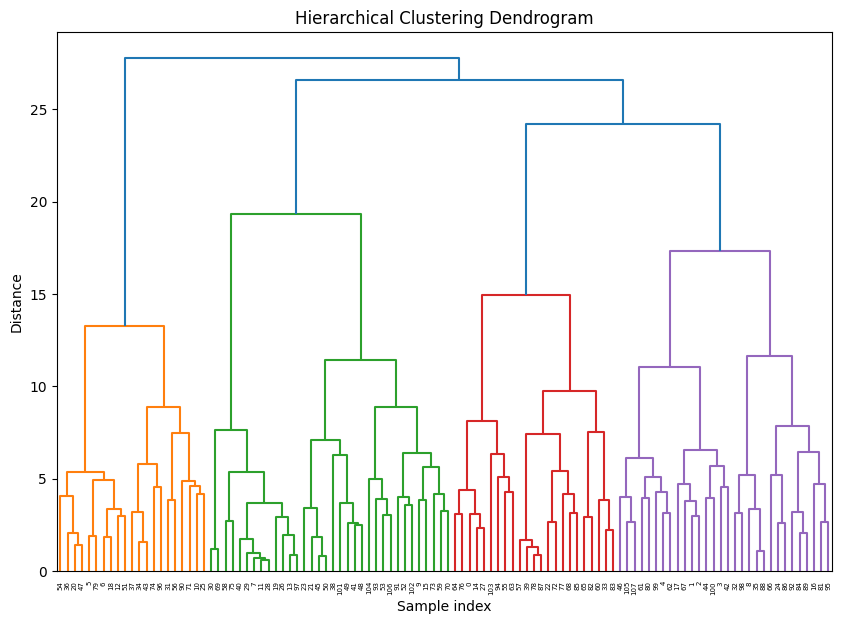

Trying value 0.5
108 [ 60  87  88  93  84   5   7  28  99  51  18  26   9  31  58  52 108  90
   8  34   1  37  69  38 100  19  33  59  27  29  22  16  95  76  11  97
   3  13  43  67  30  39  94  12  91  35  81   2  40  41  36  10  48  44
   4  61  17  68  24  53  78  82  85  62  56  74 102  89  71  23  54  20
  70  55  14  25  57  73  65   6  83 106  75  77 103  72 101  66  98 104
  21  50 105  46  63 107  15  32  96  86  92  42  49  64  47  79  45  80]
Trying value 0.7727272727272727
106 [ 58  85  86  91  82   5   7  26  97  49  18  26   9  29  56  50 106  88
   8  32   1  35  67  36  98  19  31  57  26  27  22  16  93  74  11  95
   3  13  41  65  28  37  92  12  89  33  79   2  38  39  34  10  46  42
   4  59  17  66  24  51  76  80  83  60  54  72 100  87  69  23  52  20
  68  53  14  25  55  71  63   6  81 104  73  75 101  70  99  64  96 102
  21  48 103  44  61 105  15  30  94  84  90  40  47  62  45  77  43  78]
Trying value 1.0454545454545454
102 [ 55  81  82  87  78   5   7 

topics  sentiment  page_views  \
0    [Politik, International politik, Konflikt og k...     0.7694     46684.0   
1    [Erhverv, Privat virksomhed, Samfund, Økonomi,...     0.5055     70873.0   
2    [Erhverv, Privat virksomhed, Økonomi, Mikro, P...     0.9404     22345.0   
3            [Erhverv, Samfund, Økonomi, Mikro, Bolig]     0.7033     13556.0   
4              [Erhverv, Privat virksomhed, Teknologi]     0.6230    191425.0   
..                                                 ...        ...         ...   
103  [Samfund, Værdier, Politik, International poli...     0.7679     81190.0   
104  [Kriminalitet, Transportmiddel, Bil, Politik, ...     0.8517     79741.0   
105  [Erhverv, Privat virksomhed, Transportmiddel, ...     0.9843    189087.0   
106                             [Transportmiddel, Bil]     0.7226    111784.0   
107  [Erhverv, Privat virksomhed, Transportmiddel, ...     0.8564     74195.0   

         time_published  hour  cluster  
0   2023-05-02 13:59:14    13       15  
1   2023-05-02 11:57:09    11       25  
2   2023-05-02 13:55:16    13       25  
3   2023-04-17 15:13:41    15       27  
4   2023-05-02 12:56:56    12       24  
..                  ...   ...      ...  
103 2023-05-15 03:23:02     3       17  
104 2023-05-15 20:01:34    20       11  
105 2023-04-27 19:17:22    19       23  
106 2023-05-15 20:56:08    20       11  
107 2023-05-01 16:11:27    16       23  

[108 rows x 6 columns]

Clusters user 1404234 : [15 25 27 24  1  7 28 13  5 31  8 19 29  6  4 22  2 10 18  9 26 23 12 11
 16 14 21 20  3 30 17]
Cluster: 15


topics  sentiment  page_views  \
76  [Kendt, Politik, International politik, Konfli...     0.9879    294926.0   
14  [Politik, International politik, Konflikt og k...     0.9524    118028.0   
27  [Politik, International politik, Konflikt og k...     0.9586     99868.0   
0   [Politik, International politik, Konflikt og k...     0.7694     46684.0   
64  [Kendt, Politik, International politik, Konfli...     0.6602    186450.0   

        time_published  hour  cluster  
76 2023-05-15 13:47:52    13       15  
14 2023-05-14 11:10:49    11       15  
27 2023-05-07 23:51:53    23       15  
0  2023-05-02 13:59:14    13       15  
64 2023-04-30 08:05:30     8       15

Cluster article indices df: [76, 14, 27, 0, 64]
['2023-05-15T13:47:52.000000000']
['2023-05-14T11:10:49.000000000']
['2023-05-07T23:51:53.000000000']
['2023-05-02T13:59:14.000000000']
['2023-04-30T08:05:30.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
{15: OrderedDict([('9766042', array(['2023-05-15T13:47:52.000000000'], dtype='datetime64[ns]')), ('9764564', array(['2023-05-14T11:10:49.000000000'], dtype='datetime64[ns]')), ('9753442', array(['2023-05-07T23:51:53.000000000'], dtype='datetime64[ns]')), ('9746132', array(['2023-05-02T13:59:14.000000000'], dtype='datetime64[ns]')), ('9742635', array(['2023-04-30T08:05:30.000000000'], dtype='datetime64[ns]'))])}
Cluster: 25


topics  sentiment  \
2   [Erhverv, Privat virksomhed, Økonomi, Mikro, P...     0.9404   
1   [Erhverv, Privat virksomhed, Samfund, Økonomi,...     0.5055   
17  [Erhverv, Privat virksomhed, Kendt, Økonomi, P...     0.9774   
67  [Erhverv, Privat virksomhed, Kendt, Ansættelse...     0.5372   

       page_views      time_published  hour  cluster  
2    22345.000000 2023-05-02 13:55:16    13       25  
1    70873.000000 2023-05-02 11:57:09    11       25  
17   60489.000000 2023-04-19 14:27:40    14       25  
67  126275.443396 2002-09-22 12:30:00    12       25

Cluster article indices df: [2, 1, 17, 67]
['2023-05-02T13:55:16.000000000']
['2023-05-02T11:57:09.000000000']
['2023-04-19T14:27:40.000000000']
['2002-09-22T12:30:00.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
{15: OrderedDict([('9766042', array(['2023-05-15T13:47:52.000000000'], dtype='datetime64[ns]')), ('9764564', array(['2023-05-14T11:10:49.000000000'], dtype='datetime64[ns]')), ('9753442', array(['2023-05-07T23:51:5

topics  sentiment  page_views  \
42  [Erhverv, Privat virksomhed, Samfund, Værdier,...     0.8543    167862.0   
3           [Erhverv, Samfund, Økonomi, Mikro, Bolig]     0.7033     13556.0   

        time_published  hour  cluster  
42 2023-04-30 04:41:02     4       27  
3  2023-04-17 15:13:41    15       27

Cluster article indices df: [42, 3]
['2023-04-30T04:41:02.000000000']
['2023-04-17T15:13:41.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
{15: OrderedDict([('9766042', array(['2023-05-15T13:47:52.000000000'], dtype='datetime64[ns]')), ('9764564', array(['2023-05-14T11:10:49.000000000']

topics  sentiment  page_views  \
80  [Kriminalitet, Bedrageri, Erhverv, Privat virk...     0.9832     99863.0   
62  [Erhverv, Privat virksomhed, Livsstil, Mad og ...     0.8176    194232.0   
4             [Erhverv, Privat virksomhed, Teknologi]     0.6230    191425.0   
99  [Kriminalitet, Erhverv, Privat virksomhed, Liv...     0.5089    136224.0   
61  [Kriminalitet, Erhverv, Ansættelsesforhold, Of...     0.9761    227095.0   

        time_published  hour  cluster  
80 2023-05-11 17:05:54    17       24  
62 2023-05-08 12:32:17    12       24  
4  2023-05-02 12:56:56    12       24  
99 2023-04-28 20:27:22    20       24  
61 2023-04-27 19:39:59    19       24

Cluster article indices df: [80, 62, 4, 99, 61]
['2023-05-11T17:05:54.000000000']
['2023-05-08T12:32:17.000000000']
['2023-05-02T12:56:56.000000000']
['2023-04-28T20:27:22.000000000']
['2023-04-27T19:39:59.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , ti

topics  sentiment  page_views  \
18   [Kendt, Underholdning, Film og tv, Musik og lyd]     0.9943     72986.0   
12       [Kendt, Livsstil, Underholdning, Film og tv]     0.9573    111808.0   
6    [Kendt, Underholdning, Film og tv, Musik og lyd]     0.9627    234799.0   
20                 [Kendt, Underholdning, Film og tv]     0.6597    139290.0   
47                 [Kendt, Underholdning, Film og tv]     0.5219     66767.0   
54                        [Underholdning, Film og tv]     0.9787    107393.0   
36                 [Kendt, Underholdning, Film og tv]     0.7940    151441.0   
79               [Kendt, Underholdning, Musik og lyd]     0.6494    185004.0   
51  [Kendt, Livsstil, Underholdning, Film og tv, M...     0.7973     75770.0   
5                [Kendt, Underholdning, Musik og lyd]     0.9660     69287.0   

        time_published  hour  cluster  
18 2023-05-15 15:48:10    15        1  
12 2023-05-14 13:26:55    13        1  
6  2023-05-14 03:00:19     3        1  
20 2023-05-11 09:26:18     9        1  
47 2023-05-10 06:16:59     6        1  
54 2023-05-08 15:04:18    15        1  
36 2023-04-28 21:03:12    21        1  
79 2023-04-28 17:48:17    17        1  
51 2023-04-28 08:34:24     8        1  
5  2023-04-27 19:41:28    19        1

Cluster article indices df: [18, 12, 6, 20, 47, 54, 36, 79, 51, 5]
['2023-05-15T15:48:10.000000000']
['2023-05-14T13:26:55.000000000']
['2023-05-14T03:00:19.000000000']
['2023-05-11T09:26:18.000000000']
['2023-05-10T06:16:59.000000000']
['2023-05-08T15:04:18.000000000']
['2023-04-28T21:03:12.000000000']
['2023-04-28T17:48:17.000000000']
['2023-04-28T08:34:24.000000000']
['2023-04-27T19:41:28.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:0

topics  sentiment  page_views  \
26          [Kriminalitet, Personfarlig kriminalitet]     0.9703    404737.0   
28          [Kriminalitet, Personfarlig kriminalitet]     0.9964     77535.0   
29          [Kriminalitet, Personfarlig kriminalitet]     0.9965     39940.0   
19  [Kriminalitet, Personfarlig kriminalitet, Band...     0.9963    182170.0   
13          [Kriminalitet, Personfarlig kriminalitet]     0.9966    178037.0   
97          [Kriminalitet, Personfarlig kriminalitet]     0.9962    111803.0   
58                                     [Kriminalitet]     0.9966     54309.0   
11          [Kriminalitet, Personfarlig kriminalitet]     0.9873     55713.0   
75                         [Kriminalitet, Katastrofe]     0.9951    108257.0   
40          [Kriminalitet, Personfarlig kriminalitet]     0.9807    266782.0   
7           [Kriminalitet, Personfarlig kriminalitet]     0.9872    118276.0   

        time_published  hour  cluster  
26 2023-05-11 08:07:21     8        7  
28 2023-05-02 19:59:04    19        7  
29 2023-05-02 14:51:53    14        7  
19 2023-05-02 10:13:24    10        7  
13 2023-05-02 07:01:29     7        7  
97 2023-04-29 04:08:46     4        7  
58 2023-04-27 18:04:46    18        7  
11 2023-04-27 17:33:04    17        7  
75 2023-04-27 15:14:52    15        7  
40 2023-04-26 18:40:43    18        7  
7  2023-04-26 17:40:09    17        7

Cluster article indices df: [26, 28, 29, 19, 13, 97, 58, 11, 75, 40, 7]
['2023-05-11T08:07:21.000000000']
['2023-05-02T19:59:04.000000000']
['2023-05-02T14:51:53.000000000']
['2023-05-02T10:13:24.000000000']
['2023-05-02T07:01:29.000000000']
['2023-04-29T04:08:46.000000000']
['2023-04-27T18:04:46.000000000']
['2023-04-27T17:33:04.000000000']
['2023-04-27T15:14:52.000000000']
['2023-04-26T18:40:43.000000000']
['2023-04-26T17:40:09.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4

topics  sentiment  page_views  \
8       [Erhverv, Sport, Fodbold, Ansættelsesforhold]     0.9948    185847.0   
32  [Erhverv, Privat virksomhed, Kendt, Sport, Fod...     0.6389    247406.0   
88  [Erhverv, Kendt, Sport, Fodbold, Ansættelsesfo...     0.9176     75183.0   
35  [Erhverv, Kendt, Sport, Fodbold, Ansættelsesfo...     0.7540     57868.0   
98  [Erhverv, Privat virksomhed, Sport, Fodbold, A...     0.8224    161939.0   

        time_published  hour  cluster  
8  2023-05-10 18:29:32    18       28  
32 2023-05-08 13:01:00    13       28  
88 2023-05-02 12:33:58    12       28  
35 2023-05-02 11:51:19    11       28  
98 2023-04-27 16:59:12    16       28

Cluster article indices df: [8, 32, 88, 35, 98]
['2023-05-10T18:29:32.000000000']
['2023-05-08T13:01:00.000000000']
['2023-05-02T12:33:58.000000000']
['2023-05-02T11:51:19.000000000']
['2023-04-27T16:59:12.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , ti

topics  sentiment  page_views  \
9       [Sundhed, Sygdom og behandling]     0.7305     65789.0   
15  [Konflikt og krig, Væbnet konflikt]     0.7672    133681.0   

        time_published  hour  cluster  
9  2023-05-11 15:13:41    15       13  
15 2023-04-29 18:01:36    18       13

Cluster article indices df: [9, 15]
['2023-05-11T15:13:41.000000000']
['2023-04-29T18:01:36.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Article

topics  sentiment  page_views  \
90  [Erhverv, Privat virksomhed, Kendt, Underholdn...     0.9350     35967.0   
25  [Kendt, Underholdning, Film og tv, Samfund, Væ...     0.8832     52996.0   
71  [Kriminalitet, Kendt, Underholdning, Film og t...     0.9967     86058.0   
10      [Underholdning, Film og tv, Samfund, Værdier]     0.9175     89057.0   

        time_published  hour  cluster  
90 2023-05-09 23:20:52    23        5  
25 2023-05-08 03:42:34     3        5  
71 2023-05-02 16:22:55    16        5  
10 2023-04-27 21:02:11    21        5

Cluster article indices df: [90, 25, 71, 10]
['2023-05-09T23:20:52.000000000']
['2023-05-08T03:42:34.000000000']
['2023-05-02T16:22:55.000000000']
['2023-04-27T21:02:11.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.0000000

topics  sentiment  page_views  \
81   [Kendt, Begivenhed, Sport, Ketcher- og batsport]     0.9515     42884.0   
16  [Kendt, Underholdning, Film og tv, Begivenhed,...     0.9578     45878.0   
95       [Kendt, Begivenhed, Sport, Sportsbegivenhed]     0.9665     92651.0   

        time_published  hour  cluster  
81 2023-05-15 06:25:58     6       31  
16 2023-05-08 14:57:42    14       31  
95 2023-04-28 21:21:30    21       31

Cluster article indices df: [81, 16, 95]
['2023-05-15T06:25:58.000000000']
['2023-05-08T14:57:42.000000000']
['2023-04-28T21:21:30.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  page_views  \
21       [Katastrofe, Mindre ulykke]     0.9078    181576.0   
50       [Katastrofe, Mindre ulykke]     0.9898    237747.0   
45       [Katastrofe, Mindre ulykke]     0.9670    175625.0   
23  [Katastrofe, Mindre ulykke, Dyr]     0.9902       683.0   

        time_published  hour  cluster  
21 2023-05-14 14:16:51    14        8  
50 2023-05-08 01:59:18     1        8  
45 2023-04-28 02:42:59     2        8  
23 2023-04-27 08:51:14     8        8

Cluster article indices df: [21, 50, 45, 23]
['2023-05-14T14:16:51.000000000']
['2023-05-08T01:59:18.000000000']
['2023-04-28T02:42:59.000000000']
['2023-04-27T08:51:14.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.0000000

topics  sentiment  page_views  \
72  [Politik, International politik, Konflikt og k...     0.9730     67510.0   
22                   [Politik, International politik]     0.9566    116671.0   

        time_published  hour  cluster  
72 2023-05-02 10:23:18    10       19  
22 2023-04-27 06:10:12     6       19

Cluster article indices df: [72, 22]
['2023-05-02T10:23:18.000000000']
['2023-04-27T06:10:12.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Articl

topics  sentiment  page_views  \
24  [Erhverv, Underholdning, Film og tv, Sport, Fo...     0.9691    145263.0   
86        [Underholdning, Film og tv, Sport, Fodbold]     0.8898     91284.0   
66  [Livsstil, Underholdning, Film og tv, Partners...     0.7634    222067.0   

        time_published  hour  cluster  
24 2023-05-15 08:59:40     8       29  
86 2023-05-08 11:35:06    11       29  
66 2023-05-02 12:54:12    12       29

Cluster article indices df: [24, 86, 66]
['2023-05-15T08:59:40.000000000']
['2023-05-08T11:35:06.000000000']
['2023-05-02T12:54:12.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  page_views  \
69  [Kriminalitet, Kendt, Personfarlig kriminalite...     0.9967     46641.0   
30  [Kriminalitet, Kendt, Personfarlig kriminalite...     0.9399    118196.0   

        time_published  hour  cluster  
69 2023-05-02 10:41:40    10        6  
30 2023-04-27 16:59:18    16        6

Cluster article indices df: [69, 30]
['2023-05-02T10:41:40.000000000']
['2023-04-27T16:59:18.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Articl

topics  sentiment  page_views  \
31  [Kendt, Livsstil, Underholdning, Film og tv, B...     0.8787    104421.0   
56  [Kendt, Livsstil, Underholdning, Film og tv, K...     0.8733    131577.0   

        time_published  hour  cluster  
31 2023-05-10 11:58:12    11        4  
56 2023-04-29 18:52:09    18        4

Cluster article indices df: [31, 56]
['2023-05-10T11:58:12.000000000']
['2023-04-29T18:52:09.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Articl

topics  sentiment  page_views  \
83       [Økonomi, Politik, National politik, Makro]     0.9866    158351.0   
60  [Økonomi, Politik, International politik, Makro]     0.9849     59575.0   
33       [Økonomi, Politik, National politik, Makro]     0.5179    214906.0   

        time_published  hour  cluster  
83 2023-05-15 16:31:24    16       22  
60 2023-05-08 13:17:36    13       22  
33 2023-04-27 18:35:57    18       22

Cluster article indices df: [83, 60, 33]
['2023-05-15T16:31:24.000000000']
['2023-05-08T13:17:36.000000000']
['2023-04-27T18:35:57.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  page_views  \
34  [Kendt, Underholdning, Begivenhed, Musik og ly...     0.7499     62093.0   
37  [Underholdning, Begivenhed, Musik og lyd, Unde...     0.7311    317824.0   
43  [Kendt, Underholdning, Begivenhed, Musik og ly...     0.8302    133799.0   

        time_published  hour  cluster  
34 2023-05-15 08:00:04     8        2  
37 2023-04-30 06:00:47     6        2  
43 2023-04-29 20:56:42    20        2

Cluster article indices df: [34, 37, 43]
['2023-05-15T08:00:04.000000000']
['2023-04-30T06:00:47.000000000']
['2023-04-29T20:56:42.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  page_views  \
38  [Kriminalitet, Personfarlig kriminalitet, Kult...     0.9776    151262.0   

        time_published  hour  cluster  
38 2023-05-08 13:13:25    13       10

Cluster article indices df: [38]
['2023-05-08T13:13:25.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Article id 9746068 , timestamp ['2023-05-02T

topics  sentiment  page_views  \
87  [Kendt, Politik, National politik]     0.7920     82750.0   
57  [Kendt, Politik, National politik]     0.9142     51519.0   
78  [Kendt, Politik, National politik]     0.8314     91741.0   
39  [Kendt, Politik, National politik]     0.9786     56933.0   

        time_published  hour  cluster  
87 2023-05-14 17:14:04    17       18  
57 2023-05-13 05:18:57     5       18  
78 2023-04-27 13:23:57    13       18  
39 2023-03-21 17:19:30    17       18

Cluster article indices df: [87, 57, 78, 39]
['2023-05-14T17:14:04.000000000']
['2023-05-13T05:18:57.000000000']
['2023-04-27T13:23:57.000000000']
['2023-03-21T17:19:30.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.0000000

topics  sentiment  page_views  \
49        [Transportmiddel, Katastrofe, Mindre ulykke]     0.9940     52582.0   
101  [Transportmiddel, Konflikt og krig, Katastrofe...     0.9947    219823.0   
48   [Transportmiddel, Katastrofe, Mindre ulykke, S...     0.9936     74466.0   
41   [Transportmiddel, Katastrofe, Større transport...     0.9931     77516.0   

         time_published  hour  cluster  
49  2023-05-15 15:36:55    15        9  
101 2023-05-13 21:58:18    21        9  
48  2023-04-27 18:01:38    18        9  
41  2023-04-27 16:39:15    16        9

Cluster article indices df: [49, 101, 48, 41]
['2023-05-15T15:36:55.000000000']
['2023-05-13T21:58:18.000000000']
['2023-04-27T18:01:38.000000000']
['2023-04-27T16:39:15.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000

topics  sentiment  page_views  \
100  [Erhverv, Samfund, Ansættelsesforhold, Politik...     0.6408    158994.0   
44   [Erhverv, Kendt, Samfund, Værdier, Politik, Na...     0.9933    371154.0   

         time_published  hour  cluster  
100 2023-05-13 04:50:58     4       26  
44  2023-05-02 18:00:02    18       26

Cluster article indices df: [100, 44]
['2023-05-13T04:50:58.000000000']
['2023-05-02T18:00:02.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Artic

topics  sentiment  page_views  \
46   [Erhverv, Privat virksomhed, Transportmiddel, ...     0.9852    149741.0   
107  [Erhverv, Privat virksomhed, Transportmiddel, ...     0.8564     74195.0   
105  [Erhverv, Privat virksomhed, Transportmiddel, ...     0.9843    189087.0   

         time_published  hour  cluster  
46  2023-05-15 07:07:58     7       23  
107 2023-05-01 16:11:27    16       23  
105 2023-04-27 19:17:22    19       23

Cluster article indices df: [46, 107, 105]
['2023-05-15T07:07:58.000000000']
['2023-05-01T16:11:27.000000000']
['2023-04-27T19:17:22.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp 

topics  sentiment  page_views  \
52        [Økonomi, Bolig, Udlejning]     0.9708     94158.0   
102                  [Økonomi, Makro]     0.5095     52882.0   
91   [Erhverv, Kendt, Økonomi, Makro]     0.9928    141036.0   

         time_published  hour  cluster  
52  2023-05-15 18:36:09    18       12  
102 2023-05-10 06:27:30     6       12  
91  2023-04-30 04:09:07     4       12

Cluster article indices df: [52, 102, 91]
['2023-05-15T18:36:09.000000000']
['2023-05-10T06:27:30.000000000']
['2023-04-30T04:09:07.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp [

topics  sentiment  page_views  \
106                             [Transportmiddel, Bil]     0.7226    111784.0   
104  [Kriminalitet, Transportmiddel, Bil, Politik, ...     0.8517     79741.0   
53                [Kriminalitet, Transportmiddel, Bil]     0.9976     84646.0   
93     [Kriminalitet, Transportmiddel, Bil, Teknologi]     0.8718    259590.0   

         time_published  hour  cluster  
106 2023-05-15 20:56:08    20       11  
104 2023-05-15 20:01:34    20       11  
53  2023-05-08 10:44:38    10       11  
93  2023-04-29 17:23:24    17       11

Cluster article indices df: [106, 104, 53, 93]
['2023-05-15T20:56:08.000000000']
['2023-05-15T20:01:34.000000000']
['2023-05-08T10:44:38.000000000']
['2023-04-29T17:23:24.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.00000

topics  sentiment  page_views  \
94  [Kriminalitet, Personfarlig kriminalitet, Poli...     0.9873    102467.0   
55  [International politik, Konflikt og krig, Væbn...     0.9965    166772.0   
63  [Politik, International politik, Sundhed, Sygd...     0.9655    122397.0   

        time_published  hour  cluster  
94 2023-05-08 01:45:22     1       16  
55 2023-04-30 04:14:27     4       16  
63 2023-04-27 07:29:52     7       16

Cluster article indices df: [94, 55, 63]
['2023-05-08T01:45:22.000000000']
['2023-04-30T04:14:27.000000000']
['2023-04-27T07:29:52.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  \
70                  [Samfund, Bæredygtighed og klima]     0.6496   
59                       [Livsstil, Samfund, Værdier]     0.9032   
73  [Samfund, Værdier, Uddannelse, Videregående ud...     0.9207   

       page_views      time_published  hour  cluster  
70   87979.000000 2023-04-30 04:08:19     4       14  
59   80853.000000 2023-04-03 10:27:32    10       14  
73  126275.443396 2022-12-20 15:36:34    15       14

Cluster article indices df: [70, 59, 73]
['2023-04-30T04:08:19.000000000']
['2023-04-03T10:27:32.000000000']
['2022-12-20T15:36:34.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  page_views  \
82  [Kendt, Livsstil, Partnerskab, Politik, Intern...     0.9299    131197.0   
65  [Kendt, Livsstil, Partnerskab, Politik, Nation...     0.8330    138578.0   

        time_published  hour  cluster  
82 2023-05-11 04:55:43     4       21  
65 2023-05-02 17:29:59    17       21

Cluster article indices df: [82, 65]
['2023-05-11T04:55:43.000000000']
['2023-05-02T17:29:59.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Articl

topics  sentiment  page_views  \
68                        [Politik, National politik]     0.9486     86922.0   
77  [Samfund, Politik, Konflikt og krig, National ...     0.8506    119880.0   
85            [Politik, National politik, Uddannelse]     0.9759    154257.0   

        time_published  hour  cluster  
68 2023-05-13 20:39:43    20       20  
77 2023-05-12 08:01:34     8       20  
85 2023-05-12 05:13:37     5       20

Cluster article indices df: [68, 77, 85]
['2023-05-13T20:39:43.000000000']
['2023-05-12T08:01:34.000000000']
['2023-05-12T05:13:37.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  page_views  \
74  [Kriminalitet, Kendt, Underholdning, Litteratu...     0.9767    138747.0   
96  [Kendt, Underholdning, Transportmiddel, Kultur...     0.9334    252016.0   

        time_published  hour  cluster  
74 2023-05-14 05:48:20     5        3  
96 2023-05-02 10:54:53    10        3

Cluster article indices df: [74, 96]
['2023-05-14T05:48:20.000000000']
['2023-05-02T10:54:53.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Articl

topics  sentiment  page_views  \
89  [Begivenhed, Sport, Fodbold, Sportsbegivenhed]     0.6720    290101.0   
92              [Sport, Fodbold, Sportsbegivenhed]     0.8417     61160.0   
84  [Begivenhed, Sport, Fodbold, Sportsbegivenhed]     0.9522     44044.0   

        time_published  hour  cluster  
89 2023-05-14 10:35:42    10       30  
92 2023-05-02 09:55:02     9       30  
84 2023-04-27 08:30:19     8       30

Cluster article indices df: [89, 92, 84]
['2023-05-14T10:35:42.000000000']
['2023-05-02T09:55:02.000000000']
['2023-04-27T08:30:19.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['

topics  sentiment  page_views  \
103  [Samfund, Værdier, Politik, International poli...     0.7679     81190.0   

         time_published  hour  cluster  
103 2023-05-15 03:23:02     3       17

Processing user 1404234: 100%|████████████████████| 1/1 [00:03<00:00,  3.79s/it]

Cluster article indices df: [103]
['2023-05-15T03:23:02.000000000']
Cluster 15
Article id 9766042 , timestamp ['2023-05-15T13:47:52.000000000']
Article id 9764564 , timestamp ['2023-05-14T11:10:49.000000000']
Article id 9753442 , timestamp ['2023-05-07T23:51:53.000000000']
Article id 9746132 , timestamp ['2023-05-02T13:59:14.000000000']
Article id 9742635 , timestamp ['2023-04-30T08:05:30.000000000']
Cluster 25
Article id 9746258 , timestamp ['2023-05-02T13:55:16.000000000']
Article id 9745929 , timestamp ['2023-05-02T11:57:09.000000000']
Article id 9727076 , timestamp ['2023-04-19T14:27:40.000000000']
Article id 4421856 , timestamp ['2002-09-22T12:30:00.000000000']
Cluster 27
Article id 9742627 , timestamp ['2023-04-30T04:41:02.000000000']
Article id 9723873 , timestamp ['2023-04-17T15:13:41.000000000']
Cluster 24
Article id 9759929 , timestamp ['2023-05-11T17:05:54.000000000']
Article id 9754520 , timestamp ['2023-05-08T12:32:17.000000000']
Article id 9746068 , timestamp ['2023-05-02

In [9]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from time import sleep
import random
from collections import defaultdict, OrderedDict

# Dictionary containing al the relevant clustered articles per user
user_clustered_articles = {}

# Insert per user its cluster ids and corresponding articles
def insert_user_history_clusters(user_id, df, data_index_to_article_id):
    # Get all possible clusters
    clusters = df.cluster.unique()

    if TEST:
        print("Clusters user", user_id, ":", clusters)
    
    # print(df.dtypes)

    for c in clusters:
        if TEST:
            print("Cluster:", c)
        
        # Get all articles belonging to cluster c
        clustered_articles = df.loc[df['cluster'] == c].copy()
        # Sort articles history by most recent publishing date
        ca_history = clustered_articles.sort_values(by='time_published', ascending = False)
        
        if TEST:
            display(ca_history)
        
        article_id_indices = list(ca_history.index)

        if TEST:
            print("Cluster article indices df:", article_id_indices)
            
        # For each article in the history save the <article_id> as a key and the <time_published> as value
        for idx in article_id_indices:
            # print(idx)
            article_id = data_index_to_article_id[idx]
            timestamp = df.loc[[idx],['time_published']].values[0]

            if TEST:
                print(timestamp)

            if user_id not in user_clustered_articles:
                user_clustered_articles[user_id] = {}
                
            # When cluster does not yet exist for user
            if c not in user_clustered_articles[user_id]:
                user_clustered_articles[user_id][c] = OrderedDict()
                
            user_clustered_articles[user_id][c][article_id] = timestamp

        if TEST:
            for cluster, articles in user_clustered_articles[user_id].items():
                print("Cluster", cluster)
                for article_id, timestamp in articles.items():
                    print("Article id", article_id, ", timestamp", timestamp)
    
            print(user_clustered_articles[user_id])

if TEST:
    N = 1
else:
    N = len(user_articles_info)
    
pbar = tqdm(list(user_articles_info.keys())[:N])

# Loop through all users
for user_id in pbar:
    if TEST:
        user_id = example_user_id
        
    # sleep(0.25)
    pbar.set_description("Processing user %s" % user_id)

    # Sample data
    data = user_articles_info[user_id]

    data_index_to_article_id = data['index']

    data = {'topics': data['topics'],
            'sentiment': data['sentiment'],
            'page_views': data['page_views'],
           'time_published': data['time_published']}

    # Number of articles
    n_samples = len(data['page_views'])
    
    if TEST:
        print("Number of articles", n_samples)
        
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Calculate the average of these columns ignoring NaN values
    avg = df[['sentiment', 'page_views', 'time_published']].mean(skipna=True)

    # When average page view is nan take the user's average 'page_view' on average 
    # (this case only occurs when user has only one article for which this value is nan 
    if math.isnan(avg['page_views']):
        avg['page_views'] = avg_avg_user_page_views

    # Imputation by the mean
    df = df.fillna({'sentiment': avg['sentiment'], 'page_views': avg['page_views'], 'time_published': avg['time_published']})

    # User history containing only one article needs no clustering, hardcode data and continue
    if len(df.index) == 1:
        df['cluster'] = [1]
        insert_user_history_clusters(user_id, df, data_index_to_article_id)
        continue
    
    # Multi-Label Binarizer for 'topics'
    mlb = MultiLabelBinarizer()
    # Normalizer for 'page_views'
    scaler = MinMaxScaler()

    topics_encoded = mlb.fit_transform(df['topics'])
    page_views_normalized = scaler.fit_transform(df[['page_views']])
    
    # Convert 'time_published' to datetime and extract the hour
    df['time_published'] = pd.to_datetime(df['time_published'], unit='s', format='%y-%m-%d %H:%M:%S')
    df['hour'] = df['time_published'].dt.hour
    
    # Normalize the hour (0-23) to be between 0 and 1
    hour_normalized = df['hour'] / 23.0
    hour_normalized = hour_normalized.values.reshape(-1, 1)
    
    # Combine all features
    features = np.hstack((topics_encoded, df[['sentiment']].values, page_views_normalized, hour_normalized))
    
    # Define a function to calculate Gower distance
    def gower_distance(X):
        individual_variable_distances = []
        for col in range(X.shape[1]):
            if np.issubdtype(X[:, col].dtype, np.number):
                range_ = np.ptp(X[:, col])
                if range_ == 0:
                    range_ = 1  # avoid division by zero
                individual_variable_distances.append(pdist(X[:, col].reshape(-1, 1), metric='euclidean') / range_)
            else:
                individual_variable_distances.append(pdist(X[:, col].reshape(-1, 1), metric='hamming'))
        return np.sqrt(sum(individual_variable_distances))
    
    # Calculate Gower distance matrix
    gower_dist_matrix = squareform(gower_distance(features))
    
    # Perform hierarchical clustering
    Z = linkage(gower_dist_matrix, method='ward')
    
    # Calculate cophenetic distances
    c, coph_dists = cophenet(Z, pdist(gower_dist_matrix))

    if TEST:
        print("cophenetic coefficient", c)
        print("cophenetic distances", coph_dists)
        print("Number of cophenetic distances", len(coph_dists))
        print("Min cophenetic distance threshold =", math.floor(min(coph_dists)))
        print("Max cophenetic distance threshold =", math.floor(max(coph_dists)))

        # Plot the dendrogram
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 7))
        dendrogram(Z)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Sample index')
        plt.ylabel('Distance')
        plt.show()

    # Determine the range of t values from the linkage matrix
    min_distance = math.floor(min(coph_dists))
    max_distance = math.floor(max(coph_dists))

    # Extend the range slightly beyond the min and max distances
    t_values = np.linspace(min_distance + 0.5, max_distance + 0.5, 100)

    # Try different thresholds for parameter t and determine optimal value
    silhouette_scores = []

    for t in t_values:
        clusters = fcluster(Z, t, criterion='distance')
        num_clusters = len(set(clusters))

        if TEST:
            print("Trying value", t)
            print(num_clusters, clusters)
        
        if num_clusters > 1:  # Ensure there is more than one cluster
            if num_clusters >=  n_samples:
                silhouette_scores.append(-1) # Assign a low score for number of clusters not in range [2, n_samples - 1]
            else:
                score = silhouette_score(gower_dist_matrix, clusters)
                silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Assign a low score for a single cluster
    
    # Find the t value that maximizes the silhouette score
    optimal_t = t_values[np.argmax(silhouette_scores)]

    if TEST:
        print(f"Optimal t value: {optimal_t}")
        
    # Determine cluster assignments
    max_d = optimal_t  # This value could also be set based on the dendrogram
    clusters = fcluster(Z, max_d, criterion='distance')
    
    df['cluster'] = clusters

    if TEST:
        display(df)

    insert_user_history_clusters(user_id, df, data_index_to_article_id)

In [10]:
import pickle

# Write data: clustered user articles history
# Structures :
"""
{<user_id>: 
    {<cluster_id>: 
        {<article_id>: <timestamp_published>,
        <article_id>: <timestamp_published>,
        …,
        <article_id>: <timestamp_published>}
    }
}
"""
with open('../DATA/user_history_selection/user_clustered_articles_history.pickle', 'wb') as handle:
    pickle.dump(user_clustered_articles, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Test
with open('../DATA/user_history_selection/user_clustered_articles_history.pickle', 'rb') as handle:
    file = pickle.load(handle)

K = 1
res = dict(list(file.items())[0: K])
print(res)

## DEMO

In [ ]:
# Sample data
data = {
    'article_id': [1234, 13255, 223943, 221432],
    'topics': [['politics', 'economy'], ['technology'], ['health', 'science'], ['sports']],
    'sentiment': [-1, 0, 1, 0],
    'page_views': [100, 200, 300, 150],
    'time_published': [1609459200, 1609545600, 1609632000, 1609718400]  # Unix timestamps
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Multi-Label Binarizer for 'topics' 
mlb = MultiLabelBinarizer()
topics_encoded = mlb.fit_transform(df['topics'])

# Normalize 'page_views'
scaler = MinMaxScaler()
page_views_normalized = scaler.fit_transform(df[['page_views']])

# Convert 'time_published' to datetime and extract the hour
df['time_published'] = pd.to_datetime(df['time_published'], unit='s')
df['hour'] = df['time_published'].dt.hour

# Normalize the hour (0-23) to be between 0 and 1
hour_normalized = df['hour'] / 23.0
hour_normalized = hour_normalized.values.reshape(-1, 1)

# Combine all features
features = np.hstack((topics_encoded, df[['sentiment']].values, page_views_normalized, hour_normalized))

# Define a function to calculate Gower distance
def gower_distance(X):
    individual_variable_distances = []
    for col in range(X.shape[1]):
        if np.issubdtype(X[:, col].dtype, np.number):
            range_ = np.ptp(X[:, col])
            if range_ == 0:
                range_ = 1  # avoid division by zero
            individual_variable_distances.append(pdist(X[:, col].reshape(-1, 1), metric='euclidean') / range_)
        else:
            individual_variable_distances.append(pdist(X[:, col].reshape(-1, 1), metric='hamming'))
    return np.sqrt(sum(individual_variable_distances))

# Calculate Gower distance matrix
gower_dist_matrix = squareform(gower_distance(features))

# Perform hierarchical clustering
Z = linkage(gower_dist_matrix, method='ward')

# Plot the dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Calculate cophenetic distances
c, coph_dists = cophenet(Z, pdist(gower_dist_matrix))

print(coph_dists)
print(math.ceil(max(coph_dists)))
print(math.floor(max(coph_dists)))

# Determine cluster assignments
max_d = 3  # set this value based on the dendrogram
clusters = fcluster(Z, max_d, criterion='distance')

df['cluster'] = clusters

print(df)
display(df)